In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



# 📌 ฟังก์ชันโหลดข้อมูลและคำนวณ Indicator
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)

    # คำนวณ Indicators
    df["SMA_50"] = df["close"].rolling(window=50).mean()
    df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()
    df["RSI"] = ta.rsi(df["close"], length=14)
    df["MACD"] = ta.macd(df["close"])["MACD_12_26_9"]
    df["ATR"] = ta.atr(df["high"], df["low"], df["close"], length=14)

    df.dropna(inplace=True)  # ลบค่า NaN
    return df

# 📌 ฟังก์ชันเทรน Isolation Forest
def train_isolation_forest(df):
    # features = ["close", "volume", "SMA_50", "EMA_20", "RSI", "MACD", "ATR"]
    # คำนวณ daily return เพื่อใช้ในการตรวจจับการลดลงของราคา
    df['daily_return'] = df['close'].pct_change()  # เปลี่ยนแปลงราคาต่อวัน (percentage change)

    # ลบค่าที่เป็น NaN หรือค่าว่าง (ถ้ามี)
    df.dropna(subset=['daily_return'], inplace=True)

    # features = ["daily_return","volume", "SMA_50", "EMA_20", "RSI", "MACD", "ATR"]

    
    features = ["daily_return","volume"]

    # Standardize ข้อมูล
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])

    # เทรนโมเดล
    # model = IsolationForest(n_estimators=500, contamination=0.05, random_state=42)
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)

    # การฝึกโมเดลโดยใช้ 'daily_return' เพื่อหาความเคลื่อนไหวทางลบ (negative outliers)
    df['outlier'] = model.fit_predict(df[['daily_return', 'volume']])

    # ค่าที่เป็น Outlier จะถูกติดป้าย -1 (negative outliers)
    negative_outliers = df[df['outlier'] == -1]

    # # ทำนาย Outlier
    # df["anomaly"] = model.predict(X)
    # df["anomaly_score"] = model.decision_function(X)

    return df

# 📌 ฟังก์ชันสร้างสัญญาณเข้าเทรด
# def generate_trade_signals(df):
#     df["long_signal"] = (df["anomaly"] == -1) & (df["RSI"] < 30)
#     df["short_signal"] = (df["anomaly"] == -1) & (df["RSI"] > 70)
#     return df

# 📌 ฟังก์ชันสร้างสัญญาณเข้าเทรด (เพิ่มเงื่อนไข)
# def generate_trade_signals(df):
#     # สัญญาณซื้อ (Long Signal)
#     df["long_signal"] = (
#         (df["anomaly"] == -1) &   # เป็น Outlier
#         (df["RSI"] < 30) &        # RSI < 30 (Oversold)
#         # (df["MACD"] > df["MACD_Signal"]) &  # MACD > Signal Line (โมเมนตัมขาขึ้น)
#         (df["close"] > df["EMA_20"])        # ราคาปิดสูงกว่า EMA 20
#     )

#     # สัญญาณขาย (Short Signal)
#     df["short_signal"] = (
#         (df["anomaly"] == -1) &   # เป็น Outlier
#         (df["RSI"] > 70) &        # RSI > 70 (Overbought)
#         # (df["MACD"] < df["MACD_Signal"]) &  # MACD < Signal Line (โมเมนตัมขาลง)
#         (df["close"] < df["EMA_20"])        # ราคาปิดต่ำกว่า EMA 20
#     )

#     return df



# 📌 ฟังก์ชันวาดกราฟ
def plot_results(df):
    plt.figure(figsize=(12,6))

    # วาดเส้นราคาปิด
    plt.plot(df.index, df["close"], label="BTC Price", color="blue")

    # แสดงจุดที่เป็น Outlier
    outliers = df[df["anomaly"] == -1]
    plt.scatter(outliers.index, outliers["close"], color="red", label="Outlier", marker="x")

    # แสดงจุดซื้อ (สีเขียว)
    long_positions = df[df["long_signal"]]
    plt.scatter(long_positions.index, long_positions["close"], color="green", label="Buy Signal", marker="^", s=100)

    # แสดงจุดขาย (สีส้ม)
    short_positions = df[df["short_signal"]]
    plt.scatter(short_positions.index, short_positions["close"], color="orange", label="Sell Signal", marker="v", s=100)

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("BTC Price with Outliers & Trade Signals")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# 📌 ฟังก์ชันหลัก (Main Function)
def main(file_path):
    df = load_and_prepare_data(file_path)  # โหลดข้อมูล
    df = train_isolation_forest(df)  # เทรนโมเดล
    df = generate_trade_signals(df)  # สร้างสัญญาณซื้อ-ขาย
    plot_results(df)  # วาดกราฟ

    # แสดงข้อมูลท้ายตาราง
    print(df[["close", "RSI", "MACD", "anomaly", "long_signal", "short_signal"]].tail(10))

# 📌 เรียกใช้งานฟังก์ชัน
file_path = "BTC_MT5_4H.csv"  # เปลี่ยนเป็น path ของไฟล์จริง
main(file_path)


C:\Users\ไพรัตน์\AppData\Local\Temp\ipykernel_14776\1587778478.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["anomaly"] = model.predict(X_train)
C:\Users\ไพรัตน์\AppData\Local\Temp\ipykernel_14776\1587778478.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["anomaly_score"] = model.decision_function(X_train)
C:\Users\ไพรัตน์\AppData\Local\Temp\ipykernel_14776\1587778478.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

🔹 Train Set:
                        close        RSI        EMA_10  anomaly  long_signal  \
Date                                                                           
2023-10-25 00:00:00  34016.65  76.127661  33170.401520        1        False   
2023-10-25 04:00:00  34193.97  76.994948  33356.504880        1        False   
2023-10-25 08:00:00  33945.70  72.996243  33463.631266        1        False   
2023-10-25 12:00:00  34328.37  75.139398  33620.856490        1        False   
2023-10-25 16:00:00  34486.37  75.986814  33778.222583        1        False   
2023-10-25 20:00:00  34677.32  77.006884  33941.694841        1        False   
2023-10-26 00:00:00  34661.35  76.713375  34072.541233        1        False   
2023-10-26 04:00:00  34711.34  77.008779  34188.686463        1        False   
2023-10-26 08:00:00  34522.99  73.238969  34249.468925        1        False   
2023-10-26 12:00:00  34257.84  68.179080  34250.990938        1        False   

                     short

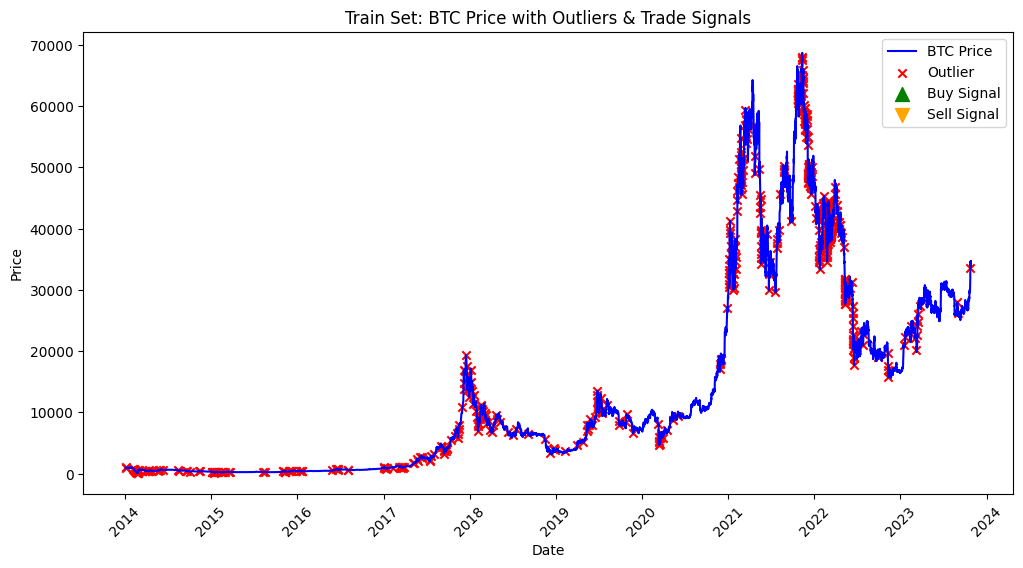

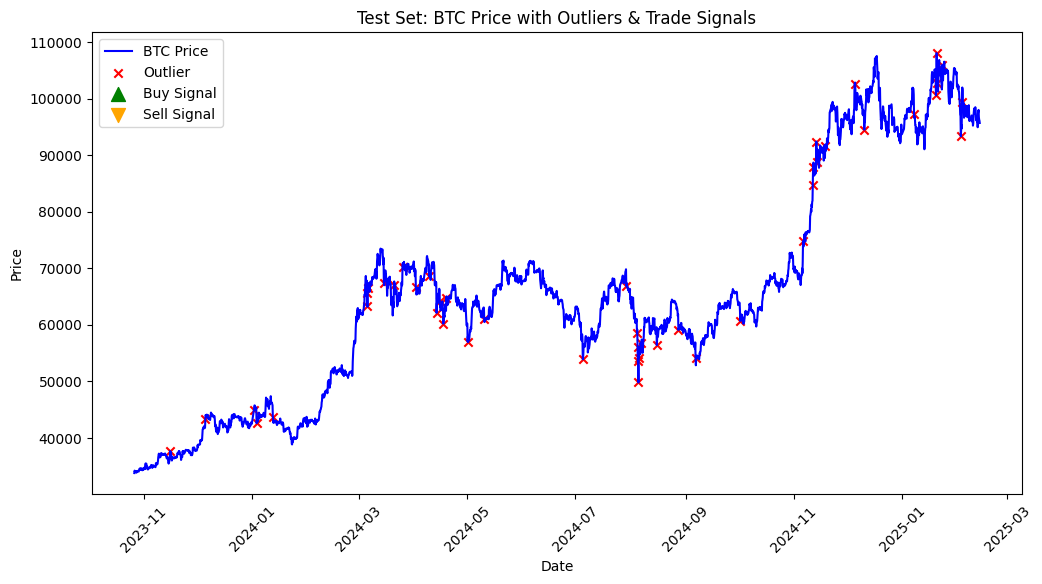

In [64]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# 📌 ฟังก์ชันโหลดข้อมูลและคำนวณ Indicator
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)

    # คำนวณ Indicators (ไม่ใช้ pandas_ta)
    df["SMA_50"] = df["close"].rolling(window=50).mean()
    df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()
    df["EMA_10"] = df["close"].ewm(span=10, adjust=False).mean()
    df["RSI"] = ta.rsi(df["close"], length=14)
    df["ATR"] = ta.atr(df["high"], df["low"], df["close"], length=14)



    # คำนวณ daily return เพื่อใช้ในการตรวจจับการลดลงของราคา
    df['daily_return'] = df['close'].pct_change()  # เปลี่ยนแปลงราคาต่อวัน (percentage change)
    # # ลบค่าที่เป็น NaN หรือค่าว่าง (ถ้ามี)
    # df.dropna(subset=['daily_return'], inplace=True)

    df.dropna(inplace=True)
    return df

# 📌 ฟังก์ชันแยก Train/Test Set
def split_train_test(df, test_size=0.2):
    train_size = int(len(df) * (1 - test_size))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    return train_df, test_df

# 📌 ฟังก์ชันเทรน Isolation Forest
def train_isolation_forest(train_df):
    # features = ["daily_return", "volume", "SMA_50", "EMA_20","EMA_10" ,"RSI", "ATR"]
    features = ["daily_return","volume"]
    # Standardize ข้อมูล
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])

    
    # เทรนโมเดล
    model = IsolationForest(n_estimators=500, contamination=0.05, random_state=42)
    model.fit(X_train)

    
  
    # ทำนาย Outlier บน Train Set
    train_df["anomaly"] = model.predict(X_train)
    train_df["anomaly_score"] = model.decision_function(X_train)

    return model, scaler, train_df

# 📌 ฟังก์ชันทดสอบโมเดลบน Test Set
def test_isolation_forest(model, scaler, test_df):
    # features = ["daily_return", "volume", "SMA_50", "EMA_20","EMA_10" ,"RSI", "ATR"]
    features = ["daily_return","volume"]
    X_test = scaler.transform(test_df[features])

    # ทำนาย Outlier บน Test Set
    test_df["anomaly"] = model.predict(X_test)
    test_df["anomaly_score"] = model.decision_function(X_test)

    return test_df

# 📌 ฟังก์ชันสร้างสัญญาณเข้าเทรด (ใช้ EMA 2 เส้นแทน MACD)
def generate_trade_signals(df):
    df["long_signal"] = (
        (df["anomaly"] == -1) &   
        (df["RSI"] < 30) &        
        (df["EMA_10"] > df["EMA_20"]) &  # EMA 20 ตัดขึ้น EMA 50 (โมเมนตัมขาขึ้น)
        (df["close"] > df["EMA_10"])     # ราคาปิดสูงกว่า EMA 20
    )

    df["short_signal"] = (
        (df["anomaly"] == -1) &   
        (df["RSI"] > 70) &        
        (df["EMA_10"] < df["EMA_20"]) &  # EMA 20 ตัดลง EMA 50 (โมเมนตัมขาลง)
        (df["close"] < df["EMA_10"])     # ราคาปิดต่ำกว่า EMA 20
    )

    return df

# 📌 ฟังก์ชันวาดกราฟผลลัพธ์
def plot_results(df, title="BTC Price with Outliers & Trade Signals"):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["close"], label="BTC Price", color="blue")

    # Outliers
    outliers = df[df["anomaly"] == -1]
    plt.scatter(outliers.index, outliers["close"], color="red", label="Outlier", marker="x")

    # Buy signals
    long_positions = df[df["long_signal"]]
    plt.scatter(long_positions.index, long_positions["close"], color="green", label="Buy Signal", marker="^", s=100)

    # Sell signals
    short_positions = df[df["short_signal"]]
    plt.scatter(short_positions.index, short_positions["close"], color="orange", label="Sell Signal", marker="v", s=100)

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# 📌 ฟังก์ชันหลัก (Main Function)
def main(file_path):
    df = load_and_prepare_data(file_path)  # โหลดข้อมูล
    train_df, test_df = split_train_test(df)  # แยก Train/Test Set

    model, scaler, train_df = train_isolation_forest(train_df)  # เทรนโมเดล
    test_df = test_isolation_forest(model, scaler, test_df)  # ทดสอบโมเดล

    train_df = generate_trade_signals(train_df)  # สร้างสัญญาณเทรดบน Train Set
    test_df = generate_trade_signals(test_df)  # สร้างสัญญาณเทรดบน Test Set

    # แสดงผลลัพธ์
    print("🔹 Train Set:")
    print(train_df[["close", "RSI", "EMA_10" ,"anomaly", "long_signal", "short_signal"]].tail(10))

    print("\n🔹 Test Set:")
    print(test_df[["close", "RSI","EMA_10" ,"anomaly", "long_signal", "short_signal"]].tail(10))

    # วาดกราฟ Train/Test
    plot_results(train_df, title="Train Set: BTC Price with Outliers & Trade Signals")
    plot_results(test_df, title="Test Set: BTC Price with Outliers & Trade Signals")

# 📌 เรียกใช้งานฟังก์ชัน
file_path = "BTC_MT5_4H.csv"  # เปลี่ยนเป็น path ของไฟล์จริง
main(file_path)
